## Link score prediction with NN ##

In [1]:
import gzip
import locale
from datetime import datetime

# Imposta locale per parsing delle date in inglese
locale.setlocale(locale.LC_TIME, 'C')

def parse_date_to_int(date_str):
    """
    Converte una data stringa in intero YYYYMMDD.
    Gestisce sia il formato esteso (19 April 2013) che abbreviato (15 Jan 2005).
    """
    if len(date_str) == 0:
        return "EMPTY_ERROR"
    
    formats_to_try = [
        "%H:%M, %d %B %Y",  # Es: "23:13, 19 April 2013"
        "%H:%M, %d %b %Y"   # Es: "23:25, 15 Jan 2005"
    ]
    for fmt in formats_to_try:
        try:
            dt_obj = datetime.strptime(date_str, fmt)
            return int(dt_obj.strftime("%Y%m%d"))
        except ValueError:
            continue
    return "ERROR_OTHERS"

def process_block(block):
    """
    Processa un blocco di linee e restituisce (SRC, TGT, VOT, DAT_int) oppure un codice errore.
    """
    # 1) Parse data
    date = block.get("DAT", "").strip()
    int_date = parse_date_to_int(date)
    if int_date in ["EMPTY_ERROR", "ERROR_OTHERS"]:
        return int_date
    
    # 2) Escludi self-loops
    if block["SRC"] == block["TGT"]:
        return "SELF_LOOP"
    
    # 3) Restituisci tupla processata
    return (block["SRC"], block["TGT"], int(block["VOT"]), int_date)

print("Print first 10 lines of the dataset:")
printed = 0
errors = {"EMPTY_ERROR": [], "SELF_LOOP": [], "ERROR_OTHERS": []}

# Dataset loading
samples = []
with gzip.open("dataset/wiki-RfA.txt.gz", "rt", encoding="utf-8", errors="ignore") as f:
    block = {}
    for line in f:
        line = line.strip()
        
        if printed < 10:
            print(line)
            printed += 1
        
        if not line:
            if "SRC" in block and "TGT" in block and "VOT" in block and "DAT" in block:
                result = process_block(block)
                if isinstance(result, str):
                    errors[result].append((block["SRC"], block["TGT"], block.get("DAT", "")))
                else:
                    samples.append(result)
            block = {}
        else:
            key, value = line.split(":", 1)
            block[key] = value.strip()

print("\n------- Dataset Loaded -------")
print(f"Total samples: {len(samples)}")
if samples:
    print(f"Example sample: {samples[0]}")

# Report errori parsing
for error_type, error_list in errors.items():
    print(f"{error_type}: {len(error_list)}")
    for edge in error_list[:4]:
        print(f"  Skipped edge: {edge}")


Print first 10 lines of the dataset:
SRC:Steel1943
TGT:BDD
VOT:1
RES:1
YEA:2013
DAT:23:13, 19 April 2013
TXT:'''Support''' as co-nom.

SRC:Cuchullain
TGT:BDD

------- Dataset Loaded -------
Total samples: 188816
Example sample: ('Steel1943', 'BDD', 1, 20130419)
EMPTY_ERROR: 9367
  Skipped edge: ('', 'Jason Quinn', '')
  Skipped edge: ('', 'Jason Quinn', '')
  Skipped edge: ('', 'Legoktm', '')
  Skipped edge: ('Majoreditor', 'Lord Roem', '')
SELF_LOOP: 88
  Skipped edge: ('Ryan Vesey', 'Ryan Vesey', '17:07, 4 July 2012')
  Skipped edge: ('Anomie', 'Anomie', '16:29, 25 September 2011')
  Skipped edge: ('Spongefrog', 'Spongefrog', '18:33, 28 September 2011')
  Skipped edge: ('Tarheel95', 'Tarheel95', '00:46, 8 December 2011')
ERROR_OTHERS: 4
  Skipped edge: ('JonasEncyclopedia', 'Zagalejo', '14:47, 1 Julu 2012')
  Skipped edge: ('HJ Mitchell', 'Alan16', '20:44, 3 Janry 2010')
  Skipped edge: ('Pathoschild', 'Werdna', '31:29, 24 May 2008')
  Skipped edge: ('QuasyBoy', 'Imdanumber1', '17:44

In [2]:
from sklearn.preprocessing import LabelEncoder
import torch

# User encoding
users = list(set([s[0] for s in samples] + [s[1] for s in samples]))
encoder = LabelEncoder()
user_ids = encoder.fit_transform(users)
user_map = dict(zip(users, user_ids))
print(f"Unique users: {len(users)}")
print(list(user_map.items())[:10])


Unique users: 11128
[('Womble', 10522), ('Uncke Herb', 9997), ('Tnfiddler', 9768), ('Okip', 7082), ('Drboggs', 2805), ('Archola', 727), ('Maveric149', 6149), ('Alastair Haines', 390), ('Lionelt', 5687), ('Cannonbolt2', 1640)]


In [3]:
# Data preparation
X = []
y = []
dates = []

for src, tgt, vot, dat in samples:
    X.append([user_map[src], user_map[tgt]])
    y.append(vot)
    dates.append(dat)

X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)

# labels per positivi: {-1,0,1} -> {1,2,3}
y_pos = y + 2
print("Positive edges:", X.size(0))


Positive edges: 188816


In [4]:
import numpy as np
import random
from collections import defaultdict

def train_val_test_split_by_date(X, y, dates, val_ratio=0.1, test_ratio=0.05):
    """
    Split cronologico: train (più vecchi), poi val, poi test (più recenti).
    """
    X_np = X.numpy()
    y_np = y.numpy()
    dates_np = np.array(dates)

    sorted_indices = np.argsort(dates_np)

    num_edges = len(dates_np)
    num_val = int(num_edges * val_ratio)
    num_test = int(num_edges * test_ratio)
    num_train = num_edges - num_val - num_test

    train_indices = sorted_indices[:num_train]
    val_indices = sorted_indices[num_train:num_train + num_val]
    test_indices = sorted_indices[num_train + num_val:]

    X_train = torch.tensor(X_np[train_indices], dtype=torch.long)
    y_train = torch.tensor(y_np[train_indices], dtype=torch.long)

    X_val = torch.tensor(X_np[val_indices], dtype=torch.long)
    y_val = torch.tensor(y_np[val_indices], dtype=torch.long)

    X_test = torch.tensor(X_np[test_indices], dtype=torch.long)
    y_test = torch.tensor(y_np[test_indices], dtype=torch.long)

    return (X_train, y_train, dates_np[train_indices]), (X_val, y_val, dates_np[val_indices]), (X_test, y_test, dates_np[test_indices])

# Split cronologico sui positivi (y_pos in {1,2,3})
(X_tr_pos, y_tr_pos, dates_tr), (X_val_pos, y_val_pos, dates_val), (X_test_pos, y_test_pos, dates_test) = train_val_test_split_by_date(X, y_pos, dates)

print(f"Training set shape: {X_tr_pos.shape} between dates {dates_tr.min()} and {dates_tr.max()}")
print(f"Validation set shape: {X_val_pos.shape} between dates {dates_val.min()} and {dates_val.max()}")
print(f"Test set shape: {X_test_pos.shape} between dates {dates_test.min()} and {dates_test.max()}")

# ---- Negative sampling (candidate-centric, leakage-free) ----
def build_voters_by_target(X_pos_tensor):
    voters = defaultdict(set)
    for u, t in X_pos_tensor.tolist():
        voters[int(t)].add(int(u))
    return voters

def sample_negatives_candidate_centric(X_pos_tensor, voters_by_target, num_nodes, neg_ratio=1, seed=42):
    rng = random.Random(seed)
    targets = X_pos_tensor[:, 1].tolist()
    X_neg = []
    for t in targets:
        t = int(t)
        forbidden = voters_by_target[t]  # unione su tutti gli split per evitare falsi negativi
        for _ in range(neg_ratio):
            while True:
                u_neg = rng.randrange(num_nodes)
                if u_neg not in forbidden:
                    X_neg.append([u_neg, t])
                    break
    return torch.tensor(X_neg, dtype=torch.long)

# Mappe voters per split e unione
voters_train = build_voters_by_target(X_tr_pos)
voters_val   = build_voters_by_target(X_val_pos)
voters_test  = build_voters_by_target(X_test_pos)

voters_all = defaultdict(set)
for d in (voters_train, voters_val, voters_test):
    for t, uset in d.items():
        voters_all[t].update(uset)

neg_ratio = 2
num_users = len(user_map)

X_tr_neg = sample_negatives_candidate_centric(X_tr_pos, voters_all, num_users, neg_ratio=neg_ratio, seed=42)
y_tr_neg = torch.zeros(X_tr_neg.size(0), dtype=torch.long)  # 0 = NoVote

X_val_neg = sample_negatives_candidate_centric(X_val_pos, voters_all, num_users, neg_ratio=neg_ratio, seed=123)
y_val_neg = torch.zeros(X_val_neg.size(0), dtype=torch.long)

X_test_neg = sample_negatives_candidate_centric(X_test_pos, voters_all, num_users, neg_ratio=neg_ratio, seed=999)
y_test_neg = torch.zeros(X_test_neg.size(0), dtype=torch.long)

# ---- Dataset 4‑classi ----
# 0 = NoVote, 1 = Oppose, 2 = Neutral, 3 = Support
X_tr_4 = torch.cat([X_tr_pos, X_tr_neg], dim=0)
y_tr_4 = torch.cat([y_tr_pos, y_tr_neg], dim=0)

X_val_4 = torch.cat([X_val_pos, X_val_neg], dim=0)
y_val_4 = torch.cat([y_val_pos, y_val_neg], dim=0)

X_test_4 = torch.cat([X_test_pos, X_test_neg], dim=0)
y_test_4 = torch.cat([y_test_pos, y_test_neg], dim=0)

print("Train 4-class size:", X_tr_4.size(0), " (pos:", X_tr_pos.size(0), "neg:", X_tr_neg.size(0), ")")
print("Val 4-class size:", X_val_4.size(0), " (pos:", X_val_pos.size(0), "neg:", X_val_neg.size(0), ")")
print("Test 4-class size:", X_test_4.size(0), " (pos:", X_test_pos.size(0), "neg:", X_test_neg.size(0), ")")


Training set shape: torch.Size([160495, 2]) between dates 20030816 and 20100413
Validation set shape: torch.Size([18881, 2]) between dates 20100413 and 20120305
Test set shape: torch.Size([9440, 2]) between dates 20120305 and 20130605
Train 4-class size: 481485  (pos: 160495 neg: 320990 )
Val 4-class size: 56643  (pos: 18881 neg: 37762 )
Test 4-class size: 28320  (pos: 9440 neg: 18880 )


In [5]:
import torch.nn as nn

# Model for vote prediction (4 classi)
class VotePredictor(nn.Module):
    def __init__(self, num_users, emb_dim=64):
        super().__init__()
        self.emb = nn.Embedding(num_users, emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 4)  # 4 classes: NoVote, Oppose, Neutral, Support
        )

    def forward(self, x):
        src_emb = self.emb(x[:, 0])
        tgt_emb = self.emb(x[:, 1])
        combined = torch.cat([src_emb, tgt_emb], dim=1)
        return self.mlp(combined)


In [6]:
from torch.nn.functional import cross_entropy
from torch.utils.data import DataLoader, TensorDataset
import torch

# Dataset e DataLoader
train_dataset = TensorDataset(X_tr_4, y_tr_4)
val_dataset   = TensorDataset(X_val_4, y_val_4)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=256)

# Model e optimizer
model = VotePredictor(num_users=len(user_map)).to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Class weights dinamici dal training set (inverse frequency, smoothed)
class_counts = torch.bincount(y_tr_4, minlength=4).float()
weights = (class_counts.sum() / (len(class_counts) * class_counts)).pow(0.5)
class_weights = weights.to("cuda")

print("Class counts:", class_counts.tolist())
print("Class weights:", class_weights.tolist())

# Early stopping
best_val_loss = float("inf")
patience, patience_counter = 3, 0

for epoch in range(1, 100): 
    # Training
    model.train()
    total_train_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to("cuda"), yb.to("cuda")
        optimizer.zero_grad()
        out = model(xb)
        loss = cross_entropy(out, yb, weight=class_weights)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to("cuda"), yb.to("cuda")
            out = model(xb)
            val_loss = cross_entropy(out, yb, weight=class_weights)
            total_val_loss += val_loss.item()

    print(f"[LSP] Epoch {epoch}, Train Loss: {total_train_loss:.4f}, Val Loss: {total_val_loss:.4f}")

    # Early stopping
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


Class counts: [320990.0, 33210.0, 9894.0, 117391.0]
Class weights: [0.6123724579811096, 1.9038246870040894, 3.4879915714263916, 1.012614130973816]
[LSP] Epoch 1, Train Loss: 1966.4874, Val Loss: 232.9484
[LSP] Epoch 2, Train Loss: 1541.5418, Val Loss: 266.4733
[LSP] Epoch 3, Train Loss: 1432.3832, Val Loss: 299.8428
[LSP] Epoch 4, Train Loss: 1384.4337, Val Loss: 307.7999
Early stopping triggered


              precision    recall  f1-score   support

      NoVote       0.71      0.85      0.77     18880
      Oppose       0.12      0.23      0.16      2221
     Neutral       0.04      0.01      0.02       587
     Support       0.42      0.07      0.12      6632

    accuracy                           0.61     28320
   macro avg       0.32      0.29      0.27     28320
weighted avg       0.58      0.61      0.56     28320



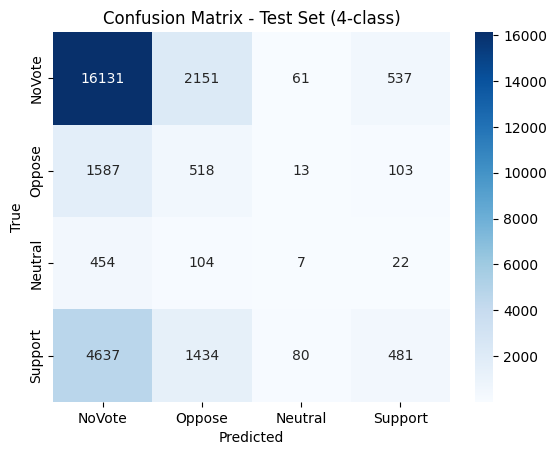

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions on the test set (4 classi)
model.eval()
with torch.no_grad():
    X_eval = X_test_4.to("cuda")
    y_pred = model(X_eval).argmax(dim=1).cpu().numpy()
    y_true = y_test_4.numpy()

# Classification report
print(classification_report(
    y_true, y_pred,
    target_names=["NoVote", "Oppose", "Neutral", "Support"]
))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=["NoVote", "Oppose", "Neutral", "Support"],
    yticklabels=["NoVote", "Oppose", "Neutral", "Support"]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set (4-class)")
plt.show()


## Link prediction with NN ##

In [10]:
import torch.nn as nn
import random
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Build dataset for link prediction
positive_edges = set((s[0], s[1]) for s in samples)

users = list(user_map.keys())

# Negative sampling: candidate-centric
def build_voters_by_target(edges):
    voters = defaultdict(set)
    for u, t in edges:
        voters[t].add(u)
    return voters

voters_all = build_voters_by_target(positive_edges)

negative_edges = set()
rng = random.Random(42)
while len(negative_edges) < len(positive_edges):
    u1, u2 = rng.sample(users, 2)
    if (u1, u2) not in positive_edges and u1 not in voters_all[u2]:
        negative_edges.add((u1, u2))

X_lp = []
y_lp = []

for src, tgt in positive_edges:
    X_lp.append([user_map[src], user_map[tgt]])
    y_lp.append(1)

for src, tgt in negative_edges:
    X_lp.append([user_map[src], user_map[tgt]])
    y_lp.append(0)

X_lp = torch.tensor(X_lp, dtype=torch.long)
y_lp = torch.tensor(y_lp, dtype=torch.float)

# Split train/val/test stratificato
X_lp_train, X_lp_temp, y_lp_train, y_lp_temp = train_test_split(
    X_lp, y_lp, test_size=0.3, random_state=42, stratify=y_lp
)
X_lp_val, X_lp_test, y_lp_val, y_lp_test = train_test_split(
    X_lp_temp, y_lp_temp, test_size=0.5, random_state=42, stratify=y_lp_temp
)

print("Train size:", len(X_lp_train))
print("Val size:", len(X_lp_val))
print("Test size:", len(X_lp_test))


Train size: 253093
Val size: 54234
Test size: 54235


In [11]:
# Model
class LinkPredictor(nn.Module):
    def __init__(self, num_users, emb_dim=64):
        super().__init__()
        self.emb = nn.Embedding(num_users, emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        src_emb = self.emb(x[:, 0])
        tgt_emb = self.emb(x[:, 1])
        combined = torch.cat([src_emb, tgt_emb], dim=1)
        return self.mlp(combined).squeeze()

from torch.utils.data import DataLoader, TensorDataset
from torch.nn.functional import binary_cross_entropy

# Dataset and DataLoader
train_lp_dataset = TensorDataset(X_lp_train, y_lp_train)
val_lp_dataset   = TensorDataset(X_lp_val, y_lp_val)

train_lp_loader = DataLoader(train_lp_dataset, batch_size=256, shuffle=True)
val_lp_loader   = DataLoader(val_lp_dataset, batch_size=256)

lp_model = LinkPredictor(num_users=len(user_map)).to("cuda")
optimizer = torch.optim.Adam(lp_model.parameters(), lr=0.001)

# Early stopping setup
best_val_loss = float("inf")
patience, patience_counter = 3, 0

# Training loop with validation
for epoch in range(1, 21):
    # Training
    lp_model.train()
    total_train_loss = 0
    for xb, yb in train_lp_loader:
        xb, yb = xb.to("cuda"), yb.to("cuda")
        optimizer.zero_grad()
        out = lp_model(xb)
        loss = binary_cross_entropy(out, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation
    lp_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_lp_loader:
            xb, yb = xb.to("cuda"), yb.to("cuda")
            out = lp_model(xb)
            val_loss = binary_cross_entropy(out, yb)
            total_val_loss += val_loss.item()
    print(f"[LP] Epoch {epoch}, Train Loss: {total_train_loss:.4f}, Val Loss: {total_val_loss:.4f}")

    # Early stopping
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


[LP] Epoch 1, Train Loss: 505.6717, Val Loss: 74.2643
[LP] Epoch 2, Train Loss: 277.2350, Val Loss: 56.2758
[LP] Epoch 3, Train Loss: 218.9814, Val Loss: 51.3964
[LP] Epoch 4, Train Loss: 192.6716, Val Loss: 49.6672
[LP] Epoch 5, Train Loss: 175.3407, Val Loss: 49.5420
[LP] Epoch 6, Train Loss: 162.7864, Val Loss: 49.9046
[LP] Epoch 7, Train Loss: 151.6794, Val Loss: 50.7392
[LP] Epoch 8, Train Loss: 141.9552, Val Loss: 52.3616
Early stopping triggered


In [12]:
from sklearn.metrics import classification_report, roc_auc_score

# Link Prediction evaluation on the test set
lp_model.eval()
with torch.no_grad():
    X_eval = X_lp_test.to("cuda")
    y_lp_pred = lp_model(X_eval).cpu().numpy()
    y_lp_true = y_lp_test.numpy()
    y_lp_bin = (y_lp_pred > 0.5).astype(int)

# Classification report
print(classification_report(y_lp_true, y_lp_bin, target_names=["NoLink", "Link"]))

# ROC-AUC
print("ROC-AUC:", roc_auc_score(y_lp_true, y_lp_pred))


              precision    recall  f1-score   support

      NoLink       0.92      0.89      0.91     27118
        Link       0.90      0.92      0.91     27117

    accuracy                           0.91     54235
   macro avg       0.91      0.91      0.91     54235
weighted avg       0.91      0.91      0.91     54235

ROC-AUC: 0.9656156636818735


## Node2vec link prediction ## 

In [ ]:
import torch
import numpy as np
import networkx as nx
from torch_geometric.nn import Node2Vec

# Build directed graph ONLY with training positive edges (no leakage)
G_train = nx.DiGraph()
for src, tgt in X_tr_pos.numpy():
    G_train.add_edge(src, tgt)

# edge_index from training graph
edges_train = np.array(G_train.edges()).T
edge_index_train = torch.tensor(edges_train, dtype=torch.long)

# Initialize Node2Vec direttamente su GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
node2vec = Node2Vec(
    edge_index_train,
    embedding_dim=64,
    walk_length=80,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    sparse=True,
    num_nodes=len(user_map)   # forza embedding per tutti gli ID
).to(device)

# Loader and optimizer
loader = node2vec.loader(batch_size=128, shuffle=True)
optimizer = torch.optim.SparseAdam(list(node2vec.parameters()), lr=0.01)

# Node2Vec training loop (su GPU)
for epoch in range(1, 15):
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = node2vec.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# Final embeddings
emb_n2v = node2vec.embedding.weight.data.cpu().numpy()

# Padding automatico se manca qualche utente
emb_dim = 64
num_users = len(user_map)
if emb_n2v.shape[0] < num_users:
    pad = np.random.normal(0, 0.01, size=(num_users - emb_n2v.shape[0], emb_dim)).astype(np.float32)
    emb_node2vec = np.vstack([emb_n2v, pad])
else:
    emb_node2vec = emb_n2v

print("emb_node2vec shape:", emb_node2vec.shape)


Epoch 1, Loss: 211.3689
Epoch 2, Loss: 97.1003
Epoch 3, Loss: 71.4618
Epoch 4, Loss: 66.3866
Epoch 5, Loss: 64.8302
Epoch 6, Loss: 64.1577
Epoch 7, Loss: 63.8018
Epoch 8, Loss: 63.5902
Epoch 9, Loss: 63.4754
Epoch 10, Loss: 63.3933
Epoch 11, Loss: 63.3311
Epoch 12, Loss: 63.2961
Epoch 13, Loss: 63.2668
Epoch 14, Loss: 63.2602
emb_node2vec shape: (11128, 64)


In [25]:
import torch.nn as nn
import torch

class Node2VecLinkPredictor(nn.Module):
    def __init__(self, num_users, emb_dim=64, emb_matrix=None):
        super().__init__()
        if emb_matrix is not None:
            # Initialize with pre‑computed Node2Vec embeddings
            self.emb = nn.Embedding.from_pretrained(
                torch.tensor(emb_matrix, dtype=torch.float),
                freeze=False   # embeddings can be fine‑tuned
            )
        else:
            self.emb = nn.Embedding(num_users, emb_dim)

        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        src_emb = self.emb(x[:, 0])
        tgt_emb = self.emb(x[:, 1])
        combined = torch.cat([src_emb, tgt_emb], dim=1)
        return self.mlp(combined).squeeze()


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.nn.functional import binary_cross_entropy

# Split train/val/test stratificato
X_lp_train, X_lp_temp, y_lp_train, y_lp_temp = train_test_split(
    X_lp, y_lp, test_size=0.3, random_state=42, stratify=y_lp
)
X_lp_val, X_lp_test, y_lp_val, y_lp_test = train_test_split(
    X_lp_temp, y_lp_temp, test_size=0.5, random_state=42, stratify=y_lp_temp
)

# Dataset and DataLoader
train_lp_dataset = TensorDataset(X_lp_train, y_lp_train)
val_lp_dataset   = TensorDataset(X_lp_val, y_lp_val)

train_lp_loader = DataLoader(train_lp_dataset, batch_size=256, shuffle=True)
val_lp_loader   = DataLoader(val_lp_dataset, batch_size=256)

# Initialize model
lp_model = Node2VecLinkPredictor(
    num_users=len(user_map),
    emb_dim=64,
    emb_matrix=emb_node2vec
).to("cuda")

optimizer = torch.optim.Adam(lp_model.parameters(), lr=0.001)

# Early stopping setup
best_val_loss = float("inf")
patience, patience_counter = 3, 0

# Training loop with validation
for epoch in range(1, 21):
    # Training
    lp_model.train()
    total_train_loss = 0
    for xb, yb in train_lp_loader:
        xb, yb = xb.to("cuda"), yb.to("cuda").float()
        optimizer.zero_grad()
        out = lp_model(xb)
        loss = binary_cross_entropy(out, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation
    lp_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_lp_loader:
            xb, yb = xb.to("cuda"), yb.to("cuda").float()
            out = lp_model(xb)
            val_loss = binary_cross_entropy(out, yb)
            total_val_loss += val_loss.item()
    print(f"[Node2Vec LP] Epoch {epoch}, Train Loss: {total_train_loss:.4f}, Val Loss: {total_val_loss:.4f}")

    # Early stopping
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


[Node2Vec LP] Epoch 1, Train Loss: 270.6587, Val Loss: 40.4195


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Link Prediction evaluation with Node2VecLinkPredictor
lp_model.eval()
with torch.no_grad():
    y_lp_pred = lp_model(X_lp_test.to("cuda")).cpu().numpy()
    y_lp_true = y_lp_test.numpy()
    y_lp_bin = (y_lp_pred > 0.5).astype(int)

# Classification report
print(classification_report(y_lp_true, y_lp_bin, target_names=["NoLink", "Link"]))

# ROC-AUC
print("ROC-AUC:", roc_auc_score(y_lp_true, y_lp_pred))


              precision    recall  f1-score   support

      NoLink       0.94      0.94      0.94     27118
        Link       0.94      0.94      0.94     27117

    accuracy                           0.94     54235
   macro avg       0.94      0.94      0.94     54235
weighted avg       0.94      0.94      0.94     54235

ROC-AUC: 0.9804449475784208


## Node2vec link score prediction ##

In [ ]:
import torch.nn as nn
import torch

class Node2VecLinkScorePredictor(nn.Module):
    def __init__(self, num_users, emb_dim=64, emb_matrix=None):
        super().__init__()
        if emb_matrix is not None:
            # Assicura contiguità e dtype float32
            emb_t = torch.as_tensor(emb_matrix, dtype=torch.float32)
            self.emb = nn.Embedding.from_pretrained(
                emb_t, freeze=False
            )
        else:
            self.emb = nn.Embedding(num_users, emb_dim)

        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 4)  # 4 classi: NoVote, Oppose, Neutral, Support
        )

    def forward(self, x):
        src_emb = self.emb(x[:, 0])
        tgt_emb = self.emb(x[:, 1])
        combined = torch.cat([src_emb, tgt_emb], dim=1)
        return self.mlp(combined)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from torch.nn.functional import cross_entropy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Split stratificato
X_train_split, X_temp, y_train_split, y_temp = train_test_split(
    X_tr_4, y_tr_4, test_size=0.3, random_state=42, stratify=y_tr_4
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Dataset e DataLoader
train_dataset = TensorDataset(X_train_split, y_train_split)
val_dataset   = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=256)

# Inizializza modello su CPU, poi sposta su GPU
lp_score_model = Node2VecLinkScorePredictor(
    num_users=len(user_map),
    emb_dim=64,
    emb_matrix=emb_node2vec
).to(device)

optimizer = torch.optim.Adam(lp_score_model.parameters(), lr=0.001)

# Class weights
class_counts = torch.bincount(y_train_split, minlength=4).float()
weights = (class_counts.sum() / (len(class_counts) * class_counts)).pow(0.5)
class_weights = weights.to(device)

print("Class counts:", class_counts.tolist())
print("Class weights:", class_weights.tolist())

# Early stopping
best_val_loss = float("inf")
patience, patience_counter = 3, 0

for epoch in range(1, 100):
    # Training
    lp_score_model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = lp_score_model(xb)
        loss = cross_entropy(out, yb, weight=class_weights)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation
    lp_score_model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = lp_score_model(xb)
            val_loss = cross_entropy(out, yb, weight=class_weights)
            total_val_loss += val_loss.item()

    print(f"[Node2Vec LSP-4] Epoch {epoch}, Train Loss: {total_train_loss:.4f}, Val Loss: {total_val_loss:.4f}")

    # Early stopping
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


Class counts: [224693.0, 23247.0, 6926.0, 82173.0]
Class weights: [0.6123719811439514, 1.9038232564926147, 3.487938642501831, 1.0126177072525024]
[Node2Vec LSP-4] Epoch 1, Train Loss: 1050.2870, Val Loss: 182.2566
[Node2Vec LSP-4] Epoch 2, Train Loss: 803.2828, Val Loss: 176.2451
[Node2Vec LSP-4] Epoch 3, Train Loss: 727.3846, Val Loss: 176.2373
[Node2Vec LSP-4] Epoch 4, Train Loss: 674.8816, Val Loss: 183.6901


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation
lp_score_model.eval()
with torch.no_grad():
    X_eval = X_test.to(device)
    y_pred = lp_score_model(X_eval).argmax(dim=1).cpu().numpy()
    y_true = y_test.numpy()  # labels in {0,1,2,3}

# Report
print(classification_report(
    y_true, y_pred,
    target_names=["NoVote", "Oppose", "Neutral", "Support"]
))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NoVote", "Oppose", "Neutral", "Support"],
            yticklabels=["NoVote", "Oppose", "Neutral", "Support"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Node2VecLinkScorePredictor (4-class)")
plt.show()


NameError: name 'lp_score_model' is not defined

## Link score prediction with BERT ##

In [18]:
import gzip

# Load dataset
samples = []
with gzip.open("dataset/wiki-RfA.txt.gz", "rt", encoding="utf-8", errors="ignore") as f:
    block = {}
    for line in f:
        line = line.strip()
        if not line:
            if "SRC" in block and "TGT" in block and "VOT" in block:
                # include TXT as well (if present)
                samples.append((
                    block["SRC"],
                    block["TGT"],
                    int(block["VOT"]),
                    block.get("TXT", "")   # textual comment
                ))
            block = {}
        else:
            key, value = line.split(":", 1)
            block[key] = value.strip()

print(f"Total samples: {len(samples)}")


Total samples: 198275


In [31]:
from sklearn.preprocessing import LabelEncoder
import torch

# Encode users as numeric IDs
users = list(set([s[0] for s in samples] + [s[1] for s in samples]))
encoder = LabelEncoder()
user_ids = encoder.fit_transform(users)
user_map = dict(zip(users, user_ids))

# Build X, y and texts lists
X, y, texts = [], [], []
for src, tgt, vot, txt in samples:
    if src in user_map and tgt in user_map:
        X.append([user_map[src], user_map[tgt]])
        y.append(vot)
        texts.append(txt if txt.strip() else "[UNK]")  # use [UNK] for missing comments

X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)


In [20]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to("cuda")

def encode_texts(texts, batch_size=32):
    all_embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
        inputs = {k: v.to("cuda") for k,v in inputs.items()}
        with torch.no_grad():
            outputs = bert_model(**inputs)
        embs = outputs.last_hidden_state[:,0,:].cpu()  # CLS token
        all_embs.append(embs)
    return torch.cat(all_embs, dim=0)


In [21]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Split X, y and raw texts
X_train, X_temp, y_train, y_temp, texts_train_raw, texts_temp_raw = train_test_split(
    X, y, texts, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test, texts_val_raw, texts_test_raw = train_test_split(
    X_temp, y_temp, texts_temp_raw, test_size=0.66, random_state=42
)


In [5]:
# Computes BERT embedding for train, val and test
texts_train = encode_texts(texts_train_raw)
texts_val   = encode_texts(texts_val_raw)
texts_test  = encode_texts(texts_test_raw)


In [22]:
# Dataset and DataLoader
train_dataset = TensorDataset(X_train, y_train, texts_train)
val_dataset   = TensorDataset(X_val, y_val, texts_val)
train_loader  = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader    = DataLoader(val_dataset, batch_size=256)

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HybridLinkScorePredictor(nn.Module):
    def __init__(self, num_users, node_emb_dim=64, text_emb_dim=768, hidden_dim=256):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, node_emb_dim)
        self.fc1 = nn.Linear(node_emb_dim*2 + text_emb_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 3)
        self.unk_text_emb = nn.Parameter(torch.zeros(1, text_emb_dim))

    def forward(self, x, text_emb=None):
        src, tgt = x[:,0], x[:,1]
        src_emb = self.user_emb(src)
        tgt_emb = self.user_emb(tgt)
        if text_emb is None:
            text_emb = self.unk_text_emb.repeat(src_emb.size(0), 1)
        h = torch.cat([src_emb, tgt_emb, text_emb], dim=1)
        h = F.relu(self.fc1(h))
        return self.fc2(h)


In [25]:
import torch.optim as optim

model = HybridLinkScorePredictor(num_users=len(user_map)).to("cuda")
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

best_val_loss = float("inf")
patience, patience_counter = 5, 0

for epoch in range(30):
    model.train()
    total_loss = 0
    for xb, yb, tb in train_loader:
        xb, yb, tb = xb.to("cuda"), yb.to("cuda"), tb.to("cuda")
        optimizer.zero_grad()
        out = model(xb, text_emb=tb)
        loss = loss_fn(out, yb + 1)  # shift labels from [-1,0,1] to [0,1,2]
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb, tb in val_loader:
            xb, yb, tb = xb.to("cuda"), yb.to("cuda"), tb.to("cuda")
            out = model(xb, text_emb=tb)
            val_loss += loss_fn(out, yb + 1).item()
    val_loss /= len(val_loader)
    print(f"[BERT LSP] Epoch {epoch}, Train Loss: {total_train_loss:.4f}, Val Loss: {total_val_loss:.4f}")

    # Early stopping (no checkpointing)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


[BERT LSP] Epoch 0, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 1, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 2, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 3, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 4, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 5, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 6, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 7, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 8, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 9, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 10, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 11, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 12, Train Loss: 206.7405, Val Loss: 63.9661
[BERT LSP] Epoch 13, Train Loss: 206.7405, Val Loss: 63.9661
Early stopping triggered


              precision    recall  f1-score   support

      Oppose       0.48      0.47      0.48      8171
     Neutral       0.16      0.28      0.20      2606
     Support       0.85      0.79      0.82     28482

    accuracy                           0.69     39259
   macro avg       0.49      0.51      0.50     39259
weighted avg       0.72      0.69      0.71     39259



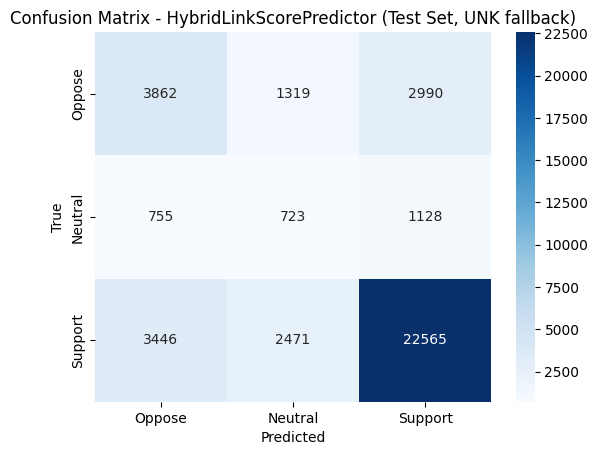

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation of HybridLinkScorePredictor
model.eval()
with torch.no_grad():
    X_eval = X_test.to("cuda")
    y_true = (y_test + 1).numpy()

    y_pred = model(X_eval).argmax(dim=1).cpu().numpy()

# Classification report
print(classification_report(y_true, y_pred, target_names=["Oppose","Neutral","Support"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Oppose","Neutral","Support"],
            yticklabels=["Oppose","Neutral","Support"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - HybridLinkScorePredictor (Test Set, UNK fallback)")
plt.show()


              precision    recall  f1-score   support

      Oppose       0.86      0.92      0.89      8171
     Neutral       0.69      0.70      0.70      2606
     Support       0.98      0.96      0.97     28482

    accuracy                           0.93     39259
   macro avg       0.84      0.86      0.85     39259
weighted avg       0.93      0.93      0.93     39259



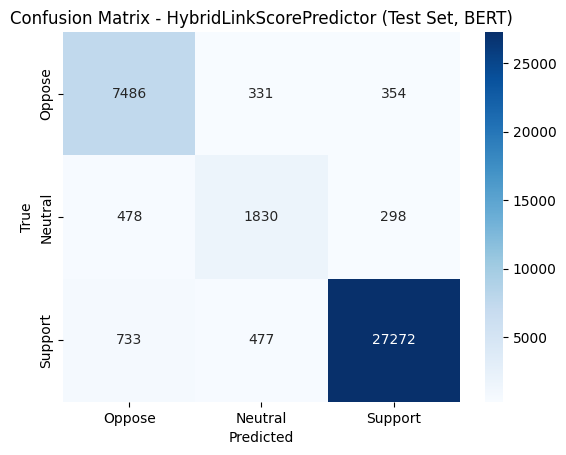

: 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# With bert test embeddings (this is considering cheating since the model can see test data comments)
model.eval()
with torch.no_grad():
    X_eval = X_test.to("cuda")
    y_true = (y_test + 1).numpy()
    y_pred = model(X_eval, text_emb=texts_test.to("cuda")).argmax(dim=1).cpu().numpy()

# Classification report
print(classification_report(y_true, y_pred, target_names=["Oppose","Neutral","Support"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Oppose","Neutral","Support"],
            yticklabels=["Oppose","Neutral","Support"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - HybridLinkScorePredictor (Test Set, BERT)")
plt.show()


##  BERT + Node2vec link score prediction ##

In [57]:
import torch
import numpy as np
import networkx as nx
from torch_geometric.nn import Node2Vec

# Costruisci grafo diretto SOLO con gli archi di training
G_train = nx.DiGraph()
for src, tgt, vot in zip(X_train_split[:,0].numpy(), X_train_split[:,1].numpy(), y_train_split.numpy()):
    G_train.add_edge(src, tgt)

# edge_index da grafo di training
edges_train = np.array(G_train.edges()).T
edge_index_train = torch.tensor(edges_train, dtype=torch.long)

# Inizializza Node2Vec
device = "cuda" if torch.cuda.is_available() else "cpu"
node2vec = Node2Vec(
    edge_index_train,
    embedding_dim=64,
    walk_length=80,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    sparse=True
).to(device)

loader = node2vec.loader(batch_size=128, shuffle=True)
optimizer = torch.optim.SparseAdam(list(node2vec.parameters()), lr=0.01)

# Training loop Node2Vec
for epoch in range(1, 15):
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = node2vec.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Node2Vec] Epoch {epoch}, Loss: {total_loss:.4f}")

# Embedding finale ricalcolato
emb_node2vec = node2vec.embedding.weight.data.cpu().numpy()


[Node2Vec] Epoch 1, Loss: 215.0695
[Node2Vec] Epoch 2, Loss: 98.2843
[Node2Vec] Epoch 3, Loss: 72.7319
[Node2Vec] Epoch 4, Loss: 67.7394
[Node2Vec] Epoch 5, Loss: 66.1837
[Node2Vec] Epoch 6, Loss: 65.5117
[Node2Vec] Epoch 7, Loss: 65.1684
[Node2Vec] Epoch 8, Loss: 64.9608
[Node2Vec] Epoch 9, Loss: 64.8462
[Node2Vec] Epoch 10, Loss: 64.7635
[Node2Vec] Epoch 11, Loss: 64.7070
[Node2Vec] Epoch 12, Loss: 64.6665
[Node2Vec] Epoch 13, Loss: 64.6353
[Node2Vec] Epoch 14, Loss: 64.6214


In [61]:
class Node2VecBertLinkScorePredictor(nn.Module):
    def __init__(self, num_users, node_emb_matrix=None, node_emb_dim=64, text_emb_dim=768, hidden_dims=[256,128]):
        super().__init__()
        if node_emb_matrix is not None:
            self.user_emb = nn.Embedding.from_pretrained(
                torch.tensor(node_emb_matrix, dtype=torch.float), freeze=False
            )
        else:
            self.user_emb = nn.Embedding(num_users, node_emb_dim)

        self.unk_text_emb = nn.Parameter(torch.zeros(1, text_emb_dim))

        input_dim = node_emb_dim*2 + text_emb_dim
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])   # 256
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])  # 128
        self.res_proj = nn.Linear(hidden_dims[0], hidden_dims[1])  # proiezione 256→128
        self.fc_out = nn.Linear(hidden_dims[1], 3)

    def forward(self, x_nodes, text_emb=None):
        src, tgt = x_nodes[:,0], x_nodes[:,1]
        src_emb = self.user_emb(src)
        tgt_emb = self.user_emb(tgt)

        if text_emb is None:
            bsz = src_emb.size(0)
            text_emb = self.unk_text_emb.repeat(bsz, 1)

        h = torch.cat([src_emb, tgt_emb, text_emb], dim=1)

        h1 = F.relu(self.fc1(h))
        h2 = F.relu(self.fc2(h1) + self.res_proj(h1))  # residual con proiezione
        return self.fc_out(h2)


In [ ]:
# Computes BERT embedding for train, val and test
texts_train = encode_texts(texts_train_raw)  # corrisponde a X_train_split
texts_val   = encode_texts(texts_val_raw)    # corrisponde a X_val
texts_test  = encode_texts(texts_test_raw)   # corrisponde a X_test


In [59]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train, texts_train)
val_dataset   = TensorDataset(X_val, y_val, texts_val)
test_dataset  = TensorDataset(X_test, y_test, texts_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=256)
test_loader  = DataLoader(test_dataset, batch_size=256)


In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Parametro di smoothing
alpha = 0.5   # puoi variare (es. 1.0 per pesi più forti)

# Conta gli esempi per ciascuna classe (shiftate da [-1,0,1] → [0,1,2])
class_counts = np.bincount((y_train + 1).numpy(), minlength=3)
total_samples = class_counts.sum()
num_classes = len(class_counts)

# Formula: w_c = (N / (C * n_c)) ** alpha
weights = (total_samples / (num_classes * class_counts)) ** alpha
class_weights = torch.tensor(weights, dtype=torch.float).to("cuda")

print("Class counts:", class_counts)
print("Class weights:", class_weights)

# Loss con pesi bilanciati
loss_fn = nn.CrossEntropyLoss(weight=class_weights)

# Modello
model = Node2VecBertLinkScorePredictor(
    num_users=len(user_map),
    node_emb_matrix=emb_node2vec
).to("cuda")

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

best_val_loss = float("inf")
patience, patience_counter = 5, 0

for epoch in range(30):
    model.train()
    total_train_loss = 0.0
    for xb, yb, tb in train_loader:
        xb, yb, tb = xb.to("cuda"), yb.to("cuda"), tb.to("cuda")
        optimizer.zero_grad()
        out = model(xb, text_emb=tb)
        loss = loss_fn(out, yb + 1)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    # Validation
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for xb, yb, tb in val_loader:
            xb, yb, tb = xb.to("cuda"), yb.to("cuda"), tb.to("cuda")
            out = model(xb, text_emb=tb)
            total_val_loss += loss_fn(out, yb + 1).item()

    print(f"[Node2Vec+BERT LSP] Epoch {epoch}, Train Loss: {total_train_loss:.4f}, Val Loss: {total_val_loss:.4f}")

    # Early stopping
    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


Class counts: [ 28882   8727 101183]
Class weights: tensor([1.2656, 2.3024, 0.6762], device='cuda:0')
[Node2Vec+BERT LSP] Epoch 0, Train Loss: 226.2816, Val Loss: 27.2685
[Node2Vec+BERT LSP] Epoch 1, Train Loss: 146.7443, Val Loss: 22.4720
[Node2Vec+BERT LSP] Epoch 2, Train Loss: 126.8748, Val Loss: 20.2422
[Node2Vec+BERT LSP] Epoch 3, Train Loss: 112.0793, Val Loss: 19.0276
[Node2Vec+BERT LSP] Epoch 4, Train Loss: 105.0045, Val Loss: 19.8121
[Node2Vec+BERT LSP] Epoch 5, Train Loss: 96.7020, Val Loss: 20.4753
[Node2Vec+BERT LSP] Epoch 6, Train Loss: 91.1582, Val Loss: 20.7305
[Node2Vec+BERT LSP] Epoch 7, Train Loss: 82.5233, Val Loss: 22.1189
[Node2Vec+BERT LSP] Epoch 8, Train Loss: 77.7617, Val Loss: 20.0012
Early stopping triggered


              precision    recall  f1-score   support

      Oppose       0.52      0.42      0.47      8171
     Neutral       0.16      0.35      0.22      2606
     Support       0.85      0.80      0.82     28482

    accuracy                           0.69     39259
   macro avg       0.51      0.52      0.50     39259
weighted avg       0.74      0.69      0.71     39259



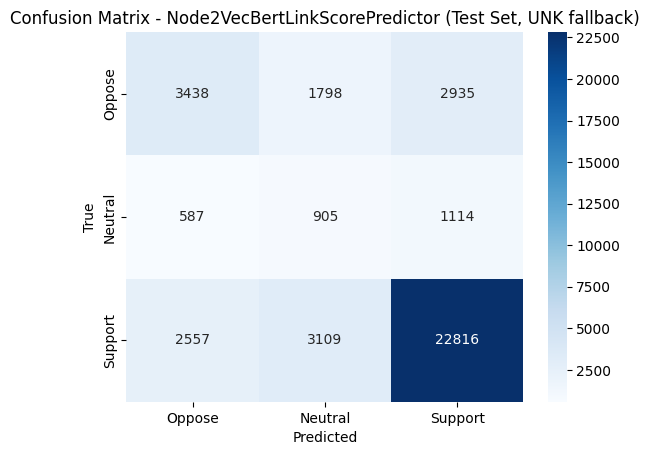

In [63]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation of Node2VecBertLinkScorePredictor (UNK fallback at test)
model.eval()
with torch.no_grad():
    X_eval = X_test.to("cuda")
    y_true = (y_test + 1).numpy()

    # Non passiamo text_emb → il forward usa self.unk_text_emb
    y_pred = model(X_eval).argmax(dim=1).cpu().numpy()

# Classification report
print(classification_report(y_true, y_pred, target_names=["Oppose","Neutral","Support"]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Oppose","Neutral","Support"],
            yticklabels=["Oppose","Neutral","Support"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Node2VecBertLinkScorePredictor (Test Set, UNK fallback)")
plt.show()
